In [1]:
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # Last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

(50000, 28, 28) (50000,)


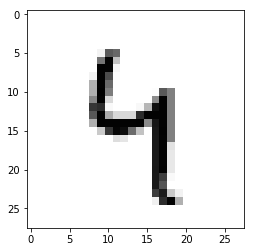

In [4]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.imshow(X_train[np.random.randint(low=0, high=X_train.shape[0])], cmap="Greys");

In [5]:
#Flattening the image as a single Dense Layer or we can say 1-hot vector

X_test = X_test.reshape((X_test.shape[0], 28*28))
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_train = X_train.reshape((X_train.shape[0], 28*28))
print("X_train.shape: " + str(X_train.shape) + "\nX_Val.shape: " + str(X_val.shape) +"\nX_test.shape: " + str(X_test.shape))

X_train.shape: (50000, 784)
X_Val.shape: (10000, 784)
X_test.shape: (10000, 784)


In [6]:
#Creating one hot vector representation of y labels. It means 5 corosponds to [0, 0, 0, 0, 0, 1, 0, 0, 0, 0].

y_train = np.eye(10)[y_train]
y_val = np.eye(10)[y_val]
y_test = np.eye(10)[y_test]
print("y_train.shape: " + str(y_train.shape) + "\ny_test.shape: " + str(y_test.shape))

y_train.shape: (50000, 10)
y_test.shape: (10000, 10)


In [7]:
#Creating Placholders for the input Values which will be fed during time of execution.

X = tf.placeholder(dtype=tf.float32, shape=(None, 28*28), name="X")
Y = tf.placeholder(dtype=tf.float32, shape=(None, 10), name="Y")
keep_prob = tf.placeholder(dtype=tf.float32, shape=(1,), name="keep_prob")

In [8]:
#Creating Variables that will take values through Training Dataset and learn according to that.

layers_arch = np.array([784, 256, 10]) 

"""
Each value in layer_arch represent the no of neurons in each layer. 
layers_arch = ["Inputlayer", "1DeepLayer", "OutputLayer"]
"""

W1 = tf.get_variable(name="W1", 
                     shape=[layers_arch[0], layers_arch[1]], 
                     dtype=tf.float32, 
                     initializer=tf.contrib.layers.xavier_initializer())

b1 = tf.get_variable(name="b1", 
                     shape=[layers_arch[1]], 
                     dtype=tf.float32, 
                     initializer=tf.contrib.layers.xavier_initializer())

W2 = tf.get_variable(name="W2", 
                     shape=[layers_arch[1], layers_arch[2]], 
                     dtype=tf.float32, 
                     initializer=tf.contrib.layers.xavier_initializer())

b2 = tf.get_variable(name="b2", 
                     shape=[layers_arch[2]], 
                     dtype=tf.float32, 
                     initializer=tf.contrib.layers.xavier_initializer())

In [9]:
#Introduce Non Linearity in the Neural Units to effectively capture the randomness of data.
#Also Introduce dropout effect to reduce overfitting.

Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.relu(Z1)
A1 = tf.nn.dropout(A1, keep_prob[0])

Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.sigmoid(Z2)


In [10]:
#Loss Function with respect to which our model will learn  parameters.
#loss = tf.reduce_mean(-tf.reduce_sum(input_y*tf.log(A3), reduction_indices=[1]))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=A2))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
#Setting up Adam Optimizer to mimimize the cross entropy cost.
#Adam because we don't have to care much oh learning rate here.

optimiser = tf.train.AdamOptimizer().minimize(loss)

In [12]:
#Initialize all variables.

init = tf.global_variables_initializer()

In [13]:
#Training and calculation of accuracy of the training on validation set.

batch_size=100
epochs = 100
keep_prob_list = np.array([0.97])

with tf.Session() as sess:
    sess.run(init)
    # Cache the cost at various steps to visualize the training and testing.
    
    train_costs = []
    test_costs = []
    
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            sess.run(optimiser, feed_dict={
                                            X: X_train[i:i+batch_size],
                                            Y: y_train[i:i+batch_size],
                                            keep_prob: keep_prob_list
                                          })
            
        train_costs.append(sess.run(loss, feed_dict={
                                                      X: X_train,
                                                      Y: y_train,
                                                      keep_prob: keep_prob_list
                                                    }))
        
        test_costs.append(sess.run(loss, feed_dict={
                                                      X: X_val,
                                                      Y: y_val,
                                                      keep_prob: keep_prob_list
                                                    }))
        
        #Print cost on every 10th iteration.
        if epoch%10 == 9:
            print("Test cost after {0} epoch: {1}".format(epoch+1, train_costs[-1]))
            
    predict_op = tf.argmax(A2, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_accuracy = accuracy.eval({X: X_train, Y: y_train, keep_prob: keep_prob_list})
    test_accuracy = accuracy.eval({X: X_test, Y: y_test, keep_prob: keep_prob_list})
    
    print("Train Accuracy:", train_accuracy*100)
    print("Test Accuracy:", test_accuracy*100)


Test cost after 10 epoch: 1.4789481163024902
Test cost after 20 epoch: 1.470159649848938
Test cost after 30 epoch: 1.4677919149398804
Test cost after 40 epoch: 1.4667285680770874
Test cost after 50 epoch: 1.4655537605285645
Test cost after 60 epoch: 1.4655239582061768
Test cost after 70 epoch: 1.465100646018982
Test cost after 80 epoch: 1.4646722078323364
Test cost after 90 epoch: 1.4648053646087646
Test cost after 100 epoch: 1.4643428325653076
Train Accuracy: 99.60200190544128
Test Accuracy: 98.01999926567078


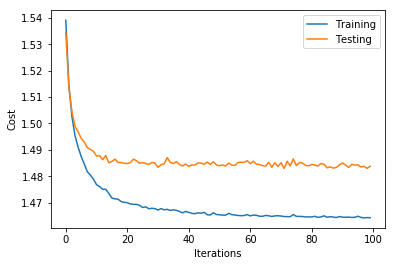

In [14]:
#Training and Testing Visualization

iteration = list(range(epochs))
plt.plot(iteration, train_costs, label="Training")
plt.plot(iteration, test_costs, label="Testing")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [15]:
train_costs[:4]

[1.5390576, 1.5146174, 1.5025871, 1.4953556]

In [16]:
test_costs[:4]

[1.5344441, 1.5135562, 1.5045182, 1.4988376]